In [7]:
import numpy as np 
import matplotlib.pyplot as plt

In [8]:
toluene = np.loadtxt('./toluene.csv', unpack=True, delimiter=',')
benzyl_alcohol = np.loadtxt('./benzyl_alcohol.csv', unpack=True, delimiter=',')
mixture = np.loadtxt('./mixture.csv', unpack=True, delimiter=',')

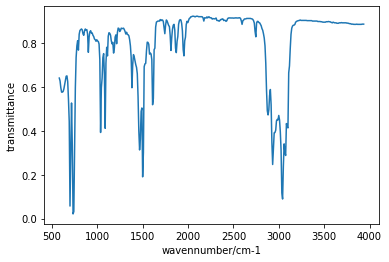

In [9]:
plt.errorbar(toluene[0], toluene[1])
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

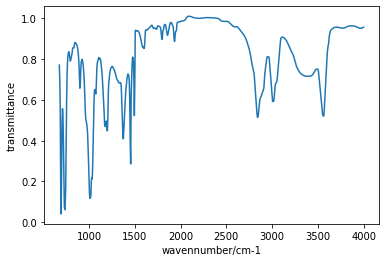

In [10]:
plt.errorbar(benzyl_alcohol[0], benzyl_alcohol[1])
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

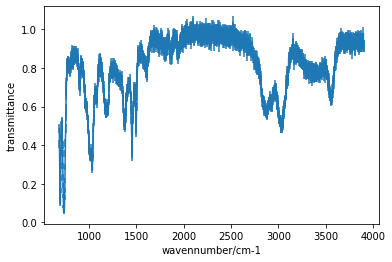

In [11]:
plt.errorbar(mixture[0], mixture[1], mixture[2])
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

In [12]:
print(np.min(benzyl_alcohol[0]), np.max(benzyl_alcohol[0]))
print(np.min(toluene[0]), np.max(toluene[0]))
print(np.min(mixture[0]), np.max(mixture[0]))

675.0 4000.0
579.481 3935.29959
686.1580790395197 3900.0


In [13]:
optimisation_x = mixture[0]

In [14]:
opt_benzyl_alcohol = np.array([optimisation_x, np.interp(optimisation_x, benzyl_alcohol[0], benzyl_alcohol[1])])
opt_toluene = np.array([optimisation_x, np.interp(optimisation_x, toluene[0], toluene[1])])

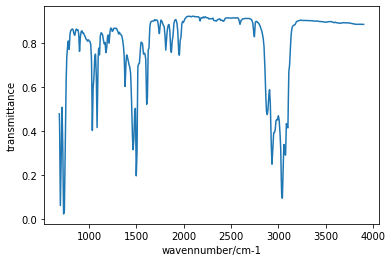

In [15]:
plt.errorbar(opt_toluene[0], opt_toluene[1])
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

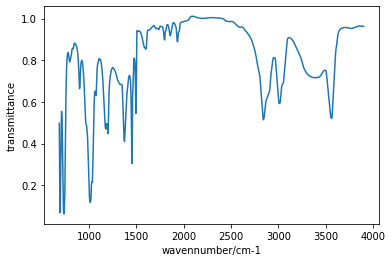

In [16]:
plt.errorbar(opt_benzyl_alcohol[0], opt_benzyl_alcohol[1])
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

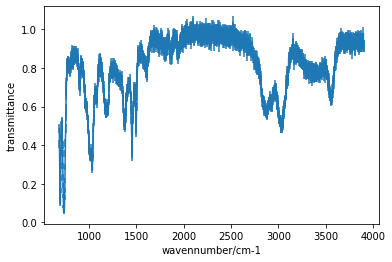

In [17]:
plt.errorbar(mixture[0], mixture[1], mixture[2])
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

In [18]:
def model(c, nu1, nu2):
    return c * nu1 + (1 - c) * nu2

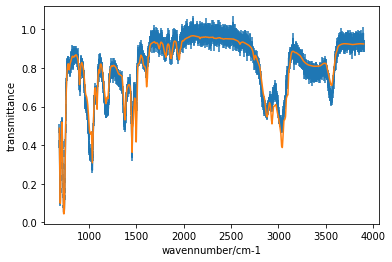

In [19]:
plt.errorbar(mixture[0], mixture[1], mixture[2])
plt.errorbar(optimisation_x, model(0.5, opt_toluene[1], opt_benzyl_alcohol[1]))
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

In [20]:
def chi(c, nu1, nu2, exp_nu, d_exp_nu):
    mod = model(c, nu1, nu2)
    chi = np.sum(np.square((mod - exp_nu) / d_exp_nu))
    return chi

In [21]:
from scipy.optimize import minimize

In [22]:
result = minimize(chi, 0.5, args=(opt_toluene[1], opt_benzyl_alcohol[1], mixture[1], mixture[2]))

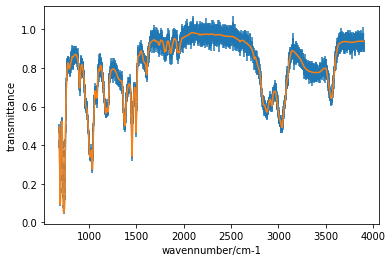

In [23]:
plt.errorbar(mixture[0], mixture[1], mixture[2])
plt.errorbar(optimisation_x, model(result.x, opt_toluene[1], opt_benzyl_alcohol[1]))
plt.xlabel('wavennumber/cm-1')
plt.ylabel('transmittance')
plt.show()

In [39]:
def mcmc(theta, model, a, data, iterations, nburn):
    accepted = []
    i = 0
    chi2 =  chi(theta, opt_toluene[1], opt_benzyl_alcohol[1], mixture[1], mixture[2])
    while i < iterations:
        new_theta = theta + a * np.random.randn(theta.size)
        new_chi2 =  chi(new_theta, opt_toluene[1], opt_benzyl_alcohol[1], mixture[1], mixture[2])
        prob = np.exp((-new_chi2 + chi2) / 2)
        n = np.random.random()
        if n < prob:
            i += 1
            theta = new_theta
            chi2 = new_chi2
            if i > nburn:
                accepted.append(theta)
    return np.array(accepted)

In [40]:
ls = mcmc(result.x, model, 0.001, mixture, 1000, 20)

<ErrorbarContainer object of 3 artists>

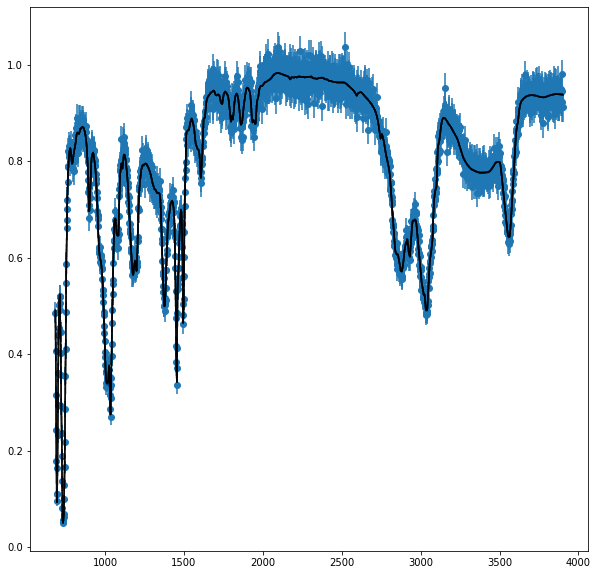

In [41]:
plt.figure(figsize=(10, 10))
for i in ls[::20]:
    plt.plot(mixture[0], model(i, opt_toluene[1], opt_benzyl_alcohol[1]), c='k', alpha=0.05, zorder=10)
plt.errorbar(mixture[0], mixture[1], mixture[2], marker='o', ls='')

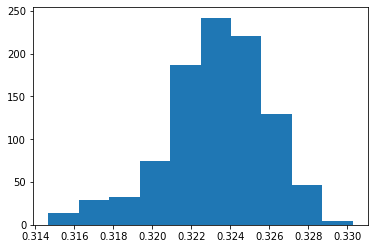

In [42]:
hi = plt.hist(ls, bins=10)

In [ ]:
h = hi[1][:-1] + (hi[1][1] - hi[1][0]) / 2

In [ ]:
h.size

In [ ]:
def normal(x, a, b, c):
    return a / np.sqrt(2 * np.pi * b ** 2) * np.exp(-(x - c) ** 2 / (2 * b ** 2))

In [ ]:
b = curve_fit(normal, h, hi[0])

In [ ]:
a, b

In [ ]:
plt.hist(ls.flatten(), bins=10)
plt.plot(hi[1][:-1], cauchy(hi[1][:-1], a[0][0], a[0][1], a[0][2]))
plt.plot(hi[1][:-1], normal(hi[1][:-1], b[0][0], b[0][1], b[0][2]))

In [ ]:
from scipy.stats import shapiro
stat, p = shapiro(np.random.choice(ls.flatten(), 5000))
print('Statistics=%.3f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

In [ ]:
from scipy.stats.mstats import mquantiles

In [ ]:
ls.flatten().mean() + 2 * ls.flatten().std(), ls.flatten().mean(), ls.flatten().mean() - 2 * ls.flatten().std()

In [ ]:
mquantiles(ls.flatten(), prob=[0.05, 0.5, 0.95])